# Single (mouse-region) analysis - Bergamo data

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from resamplers import resample_tifs
from stackers import stack_trial_tifs, split_multichannel_tifs
from filters import KalmanDenoiser
from substitutors import StackSubstitutor
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

## Parameters

### Input & output directories

In [3]:
dataroot = get_data_root()  # Root directory for raw data
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')  # Directory for output figures
logger.info(f'input data root: "{dataroot}"')
logger.info(f'output figures directory: "{figsdir}"')
figs = {}  # Figures dictionary

 16/08/2022 19:37:44: input data root: "/Users/tlemaire/Documents/data/usnm/raw"
 16/08/2022 19:37:44: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs/"


### Input dataset and main processing parameters

In [14]:
mouseline = 'cre_sst'  # mouse line
expdate = '20220712'  # experiment date
mouseid = 'justin6'  # mouse number
region = 'region1'  # brain region
layer = DEFAULT_LAYER  # cortical layer
inspect = True  # whether to inspect data for a randomly chosen run along processing steps
slack_notify = False   # notify start and completion on slack
ref_sr = BERGAMO_SR  # Hz
target_sr = BRUKER_SR  # Hz
functional_channel = FUNC_CHANNEL  # index of functional channel
um_per_px = None  # spatial resolutiuon of acquisitions (um / pixel)
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # Reference variable for post-processing  

### Derived parameters

In [5]:
# Construct dataset ID
dataset_id = f'{expdate}_{mouseid}_{region}'
if layer != DEFAULT_LAYER:
    dataset_id = f'{dataset_id}_{layer}'

# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')

# Extract input data directory
datadir = os.path.join(dataroot, mouseline, dataset_id)
if not os.path.exists(datadir):
    raise ValueError(f'input data directory "{datadir}" does not exist')
logger.info(f'input data directory: "{datadir}"')

# Extract figures suffix
figssuffix = f'{mouseline}_{dataset_id}_k{kalman_gain}_{postpro_id}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_id} notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 16/08/2022 19:37:46: input data directory: "/Users/tlemaire/Documents/data/usnm/raw/cre_sst/20220712_justin6_region1"
 16/08/2022 19:37:46: 20220712_justin6_region1 notebook started on 2022-08-16 at 19:37:46


### Input summary table figure

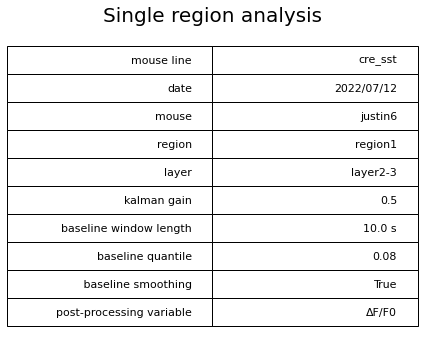

In [6]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'date': f'{expdate[:4]}/{expdate[4:6]}/{expdate[6:]}',
    'mouse': mouseid,
    'region': region,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Single region analysis')

### Intermediate data inspection

In [7]:
nROIs_inspect = 3  # number of ROIs to look at for the inspection run (if specified)
stackdict = None  # empty stacks dictionary
runbounds = None  # empty runbounds array
istimframes_stacked = None  # empty stimulus frames array
save_gifs = False  # whether to save gifs of extracted movies or not

## Pre-processing (resampling, stacking, channel splitting, substitution, denoising)

### Prepare Bergamo data and gather functional TIF stacks

 16/08/2022 19:37:54: processing files in "/Users/tlemaire/Documents/data/usnm/raw/cre_sst/20220712_justin6_region1"
 16/08/2022 19:37:54: "/Users/tlemaire/Documents/data/usnm/resampled/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05_00008.tif" already exists
 16/08/2022 19:37:54: "/Users/tlemaire/Documents/data/usnm/stacked/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif" already exists
 16/08/2022 19:37:54: loaded (100, 2, 512, 512) int16 stack from "/Users/tlemaire/Documents/data/usnm/stacked/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif"
 16/08/2022 19:37:54: "/Users/tlemaire/Documents/data/usnm/split/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif" alr

100%|██████████| 100/100 [00:00<00:00, 1931.07it/s]

 16/08/2022 19:37:54: intensity range: -19 - 834
 16/08/2022 19:37:54: adding 1 delimiters



100%|██████████| 100/100 [00:00<00:00, 1287.53it/s]

 16/08/2022 19:37:54: initializing stack viewer
 16/08/2022 19:37:54: stack size: (100, 512, 512)
 16/08/2022 19:37:54: computing stack intensity range across 0 - 99 frame range...



100%|██████████| 100/100 [00:00<00:00, 2421.96it/s]

 16/08/2022 19:37:54: intensity range: -19 - 834
 16/08/2022 19:37:54: rendering stack view...


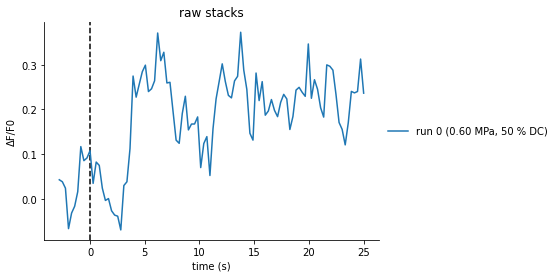

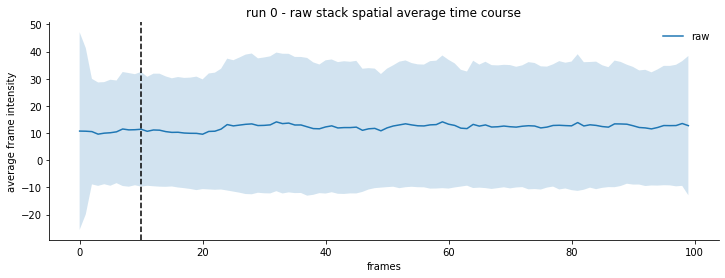

In [8]:
# Input directory for stacked data
logger.info(f'processing files in "{datadir}"')

# Get TIF stack files inside that folder
fnames = get_sorted_filelist(datadir, pattern=P_TIFFILE)
raw_fpaths = [os.path.join(datadir, fname) for fname in fnames]

# Resample TIF stacks
resampled_fpaths = resample_tifs(raw_fpaths, ref_sr, target_sr)

# Stack trial TIFs of every run in the stack list
stacked_paths = stack_trial_tifs(resampled_fpaths, overwrite=False)

# Split channels from run stacks
split_fpaths = split_multichannel_tifs(stacked_paths, overwrite=False)

# Keep only files from functional channel
channel_key = f'channel{FUNC_CHANNEL}'
func_fpaths = list(filter(lambda x: channel_key in x, split_fpaths))

# Tweak: label functional stacks as raw
raw_stack_fpaths = func_fpaths

# Extract number of runs
nruns = len(raw_stack_fpaths)
raw_stacks_str = '\n'.join([f'  - {os.path.basename(x)}' for x in raw_stack_fpaths])
logger.info(f'Identified {nruns} functional TIF stacks:\n{raw_stacks_str}')

# Determie run insepct index
irun_inspect = random.choice(np.arange(nruns)) if inspect else None # run index
stacktitle = f'run {irun_inspect}'  # default stack title

# Extract and check consistency of number of frames per run
nframes_per_run = []
for fpath in raw_stack_fpaths:
    stack_shape = loadtif(fpath).shape
    nframes_per_run.append(stack_shape[0])
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Plot trial-averaged stack frame-averaged intensity
figs['trialavg_stackavg_traces raw'] = plot_trialavg_stackavg_traces(
    raw_stack_fpaths, ntrials_per_run, title='raw stacks')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

### Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

 16/08/2022 19:39:59: loaded (100, 512, 512) int16 stack from "/Users/tlemaire/Documents/data/usnm/split/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif"
 16/08/2022 19:39:59: constructing 10-frames baseline from 100-frames stack...
 16/08/2022 19:40:00: filtering 100-frames stack with KalmanDenoiser(gain=0.5, var=0.05, npad=10)


100%|██████████| 109/109 [00:00<00:00, 426.31it/s]

 16/08/2022 19:40:01: saving (100, 512, 512) int16 stack as "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif"...


 16/08/2022 19:40:01: deriving acoustic intensity information...
 16/08/2022 19:40:01: loaded (100, 512, 512) int16 stack from "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/justin6_region1_100frames_100Hz_200ms_3.56Hz_0.60MPa_50DC-run05.tif"
 16/08/2022 19:40:01: initializing stack viewer
 16/08/2022 19:40:01: stack size: (100, 512, 512)
 16/08/2022 19:40:01: computing stack intensity range across 0 - 99 frame range...


100%|██████████| 100/100 [00:00<00:00, 2407.72it/s]

 16/08/2022 19:40:01: intensity range: -19 - 834



100%|██████████| 100/100 [00:00<00:00, 2395.43it/s]

 16/08/2022 19:40:01: intensity range: -6 - 697
 16/08/2022 19:40:01: adding 1 delimiters



100%|██████████| 100/100 [00:00<00:00, 1452.47it/s]


 16/08/2022 19:40:01: initializing stack viewer
 16/08/2022 19:40:01: stack size: (100, 512, 512)
 16/08/2022 19:40:01: computing stack intensity range across 0 - 99 frame range...


100%|██████████| 100/100 [00:00<00:00, 2428.85it/s]

 16/08/2022 19:40:01: intensity range: -19 - 834



100%|██████████| 100/100 [00:00<00:00, 2472.37it/s]

 16/08/2022 19:40:01: intensity range: -6 - 697
 16/08/2022 19:40:01: rendering stack view...


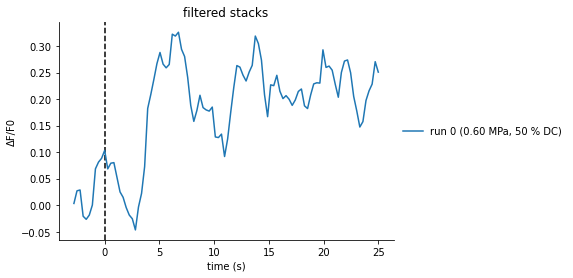

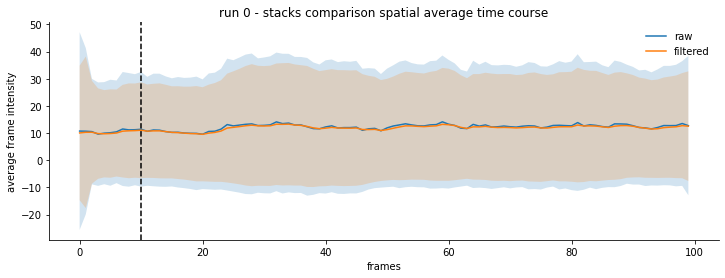

In [10]:
# Define Kalman filter
if kalman_gain is not None and kalman_gain > 0:
    kd = KalmanDenoiser(G=kalman_gain, V=0.05, npad=10)  # real filter object
else:
    kd = NoProcessor()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'split'
filtered_stack_fpaths = process_and_save(kd, raw_stack_fpaths, input_root, overwrite=False)

figs['trialavg_stackavg_traces filtered'] = plot_trialavg_stackavg_traces(
    filtered_stack_fpaths, ntrials_per_run, title='filtered stacks')

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

## Functional segmentation (suite2p)

 16/08/2022 19:42:46: parsed frame rate = 3.56 fps
 16/08/2022 19:42:46: Suite2p input directory:
/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1
 16/08/2022 19:42:46: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 16/08/2022 19:42:46: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 16/08/2022 19:42:46: found all suite2p output files in "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/channel1/sr_ref30.0_target3.56_smooth/cre_sst/20220712_justin6_region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 16/08/2022 19:42:46: run options match 100% -> ignoring
 16/08/2022 19:42:46: empty data path -> no run
 16/08/2022 19:42:46: extracted data contains 58 ROIs
 16/08/2022 19:42:46: no zero-pressure run found
 16/08/2022 19:42:46: output info table c

100%|██████████| 100/100 [00:00<00:00, 1643.01it/s]

 16/08/2022 19:42:46: intensity range: -19 - 834



100%|██████████| 100/100 [00:00<00:00, 1930.77it/s]

 16/08/2022 19:42:46: intensity range: -6 - 697
 16/08/2022 19:42:46: adding 1 delimiters



100%|██████████| 100/100 [00:00<00:00, 913.36it/s]

 16/08/2022 19:42:47: initializing stack viewer
 16/08/2022 19:42:47: stack size: (100, 512, 512)
 16/08/2022 19:42:47: frame frange: [0, 99]
 16/08/2022 19:42:47: computing stack intensity range across 0 - 99 frame range...



100%|██████████| 100/100 [00:00<00:00, 3743.21it/s]

 16/08/2022 19:42:47: intensity range: -106.0 - 1266.0



100%|██████████| 100/100 [00:00<00:00, 2235.23it/s]

 16/08/2022 19:42:47: plotting suite2p registration offsets...


 16/08/2022 19:42:47: plotting suite2p registration phase correlation peaks...
 16/08/2022 19:42:47: looks like the data was not registered -> ignoring
 16/08/2022 19:42:47: plotting suite2p registered images...
 16/08/2022 19:42:47: plotting suite2p sparse projection maps...
 16/08/2022 19:42:47: plotting suite2p identified ROIs...
 16/08/2022 19:42:48: initializing stack viewer
 16/08/2022 19:42:48: stack size: (100, 512, 512)
 16/08/2022 19:42:48: frame frange: [0, 99]
 16/08/2022 19:42:48: computing stack intensity range across 0 - 99 frame range...


100%|██████████| 100/100 [00:00<00:00, 4181.84it/s]

 16/08/2022 19:42:48: intensity range: -106.0 - 1266.0
 16/08/2022 19:42:48: rendering stack view...


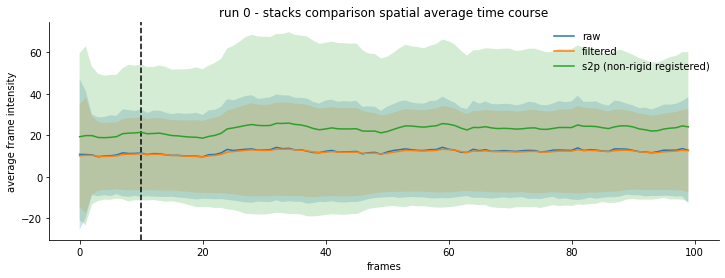

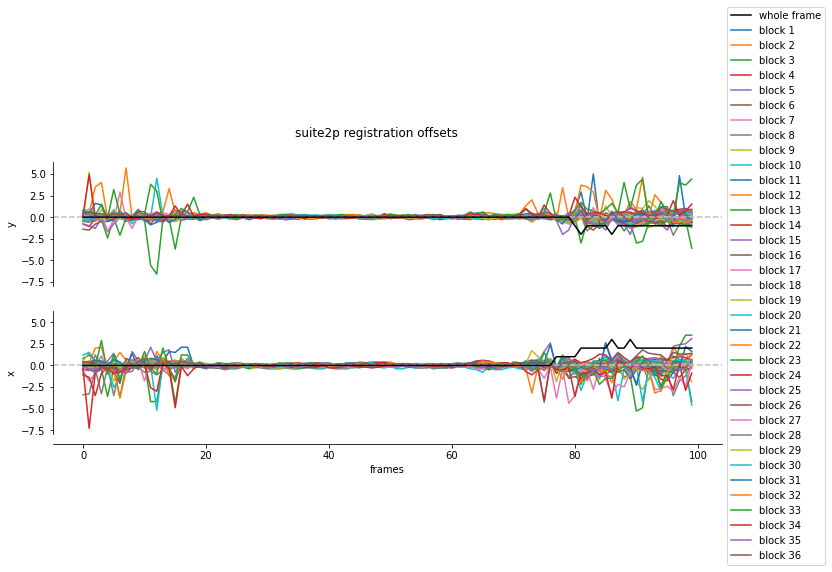

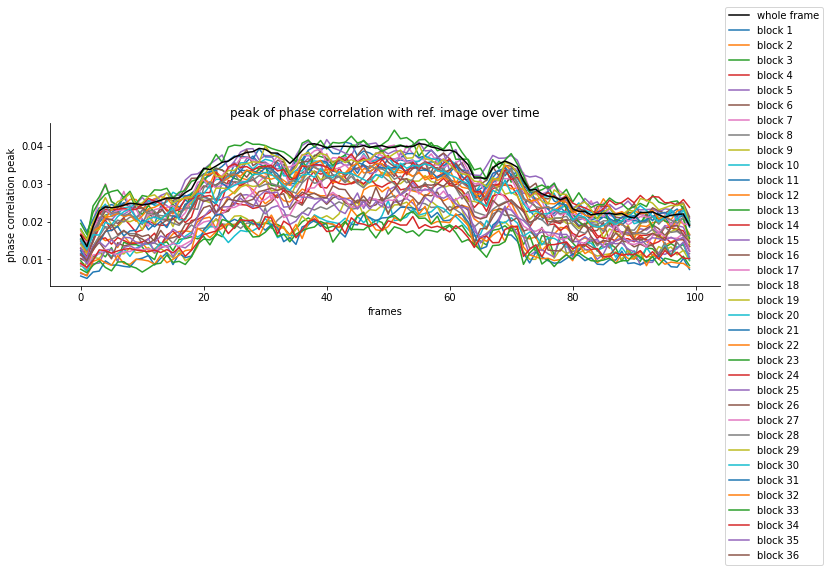

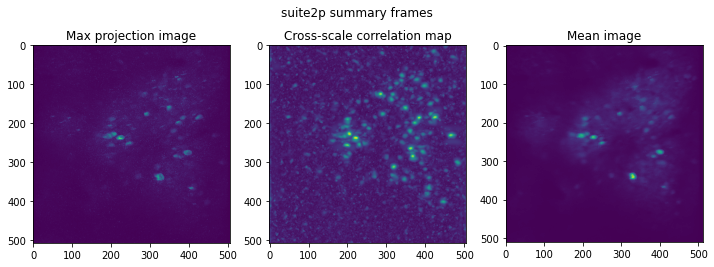

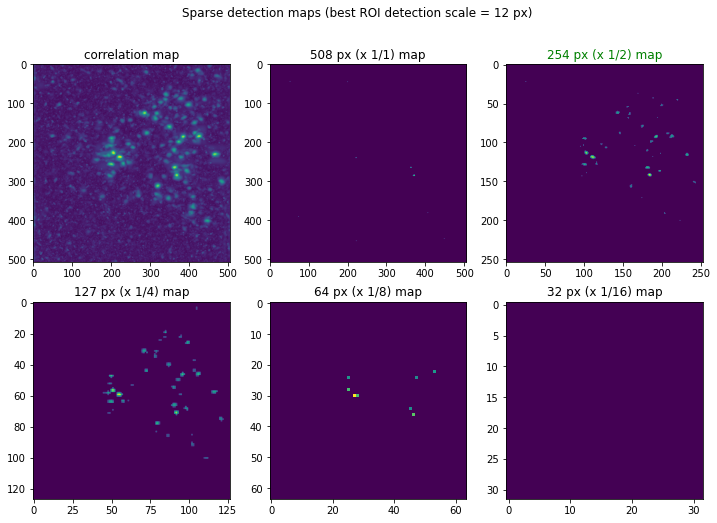

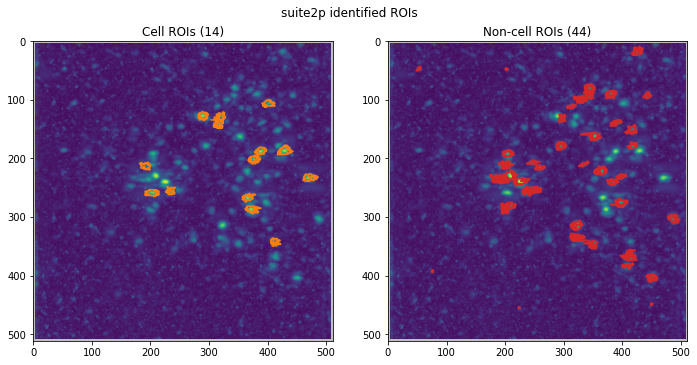

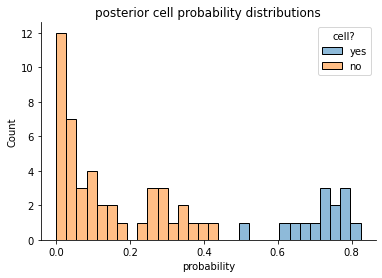

In [15]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Get index of zero pressure run
try:
    irun_P0 = output_info_table[output_info_table[Label.P] == 0.].index[0]
    logger.info(f'zero pressure run index = {irun_P0}')
except IndexError as err:
    irun_P0 = None
    logger.warning('no zero-pressure run found')

# Log info table
logger.info(
    f'output info table corresponding to suite2p processing order:\n{output_info_table}')

# If run index is defined, inspect stack metrics for that particular run
irun_eq = None
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=um_per_px)

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=um_per_px)

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=um_per_px, mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing: from raw F traces to ΔF/F and Z(ΔF/F) traces

### Load processed data if available

In [16]:
postpro_input_key = input_root if isinstance(kd, NoProcessor) else 'filtered'
s2p_line_dir = os.path.join(*split_path_at(s2p_input_dir, mouseline)[:2])
postpro_dir = get_output_equivalent(
    s2p_line_dir, postpro_input_key, f'post-processed/{baseline_id}')
postpro_fpath = os.path.join(postpro_dir, f'{dataset_id}.h5')
try:
    logger.info('loading data...')
    xtimeseries, output_info_table, ROI_masks = load_postpro_dataset(postpro_fpath)
    is_postpro_data_available = True
    logger.info(f'experiment info table:\n{output_info_table}')
    logger.info(f'post-processed timeseries: {describe_dataframe_index(xtimeseries)} dataframe')
    logger.info(f'ROI masks: {describe_dataframe_index(ROI_masks)} dataframe')
except FileNotFoundError as err:
    logger.warning(err)
    is_postpro_data_available = False

 16/08/2022 19:43:35: loading data...
 16/08/2022 19:43:35: post-processed data file not found in directory


### Get fluorescence timeseries data

 16/08/2022 19:44:02: assembled (14 ROIs x 100 frames) fluorescence timeseries dataframe
 16/08/2022 19:44:02: splitting fluorescence data into 1 separate runs...
 16/08/2022 19:44:02: reshaped dataframe into (14 ROIs x 1 run x 100 frames) form
 16/08/2022 19:44:02: splitting fluorescence data into 1 separate trials...
 16/08/2022 19:44:02: reshaped dataframe into (14 ROIs x 1 run x 1 trial x 100 frames) form
 16/08/2022 19:44:02: adding time info to table...
 16/08/2022 19:44:02: discarding non-cell ROIs...
 16/08/2022 19:44:02: filtered to 14 ROIs x 1 run x 1 trial x 100 frames fluorescence timeseries dataframe
 16/08/2022 19:44:02: identifying outliers with zero fluorescence traces...
 16/08/2022 19:44:02: updating dataset...
 16/08/2022 19:44:02: filtered to 14 ROIs x 1 run x 1 trial x 100 frames fluorescence timeseries dataframe
 16/08/2022 19:44:02: plotting suite2p identified ROIs...
 16/08/2022 19:44:02: plotting F_ROI (a.u.) traces of all 14 ROIs...
 16/08/2022 19:44:02: group

IndexError: list index out of range

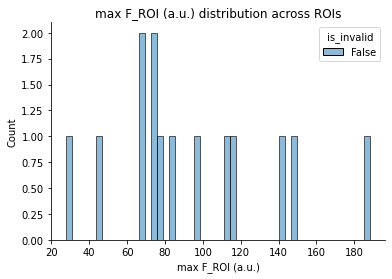

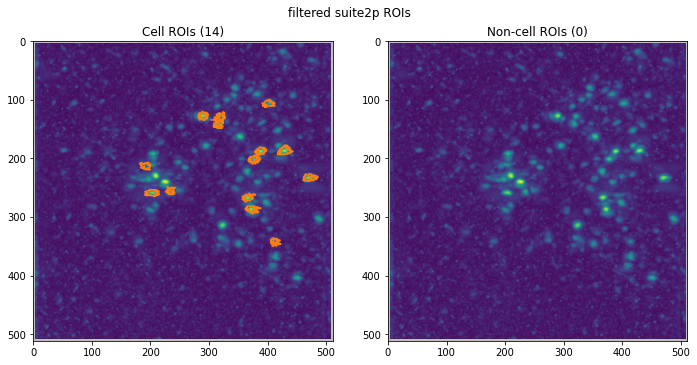

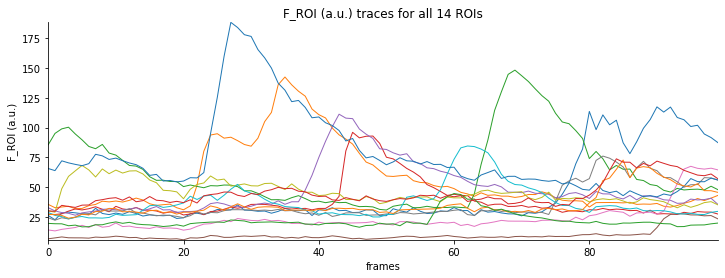

In [19]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
raw_timeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(raw_timeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
raw_timeseries = separate_runs(raw_timeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
raw_timeseries = separate_trials(raw_timeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Add time to table
raw_timeseries[Label.FPS] = fps
raw_timeseries = add_time_to_table(raw_timeseries)
# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
raw_timeseries = raw_timeseries.loc[(icells), :]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI
    # and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index), :]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=um_per_px, superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = raw_timeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Identify invalid ROIs with zero F_ROI range 
logger.info('identifying outliers with zero fluorescence traces...')
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
raw_timeseries = raw_timeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=um_per_px, superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_ROI_traces(raw_timeseries, Label.F_ROI)

# Plot aggregate traces
figs[f'{Label.F_ROI} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F_ROI, Label.F_NEU], itrial=slice(1, 16))

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = raw_timeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    iROI_inspect = np.random.choice(iROIs, size=nROIs_inspect)
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_multivar_traces(
        raw_timeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

In [15]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients using robust linear regression
# nROIs = len(raw_timeseries.index.unique(Label.ROI))
# logger.info(f'computing alphas using robust linear regression ...')
# groups = raw_timeseries.groupby(Label.ROI)
# with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
#     regparams = groups.apply(pbar_update(
#         lambda df: robust_linreg(df[Label.F_ROI].values, df[Label.F_NEU].values), pbar))
# regparams = pd.DataFrame(
#     regparams.tolist(), index=regparams.index, columns=['beta', 'alpha'])
# figs['reg params'], ax = plt.subplots()
# sns.despine(ax=ax)
# sns.scatterplot(data=regparams, x='alpha', y='beta', ax=ax)

# Compute ROI-specific neuropil coefficients minimizing specific cost function
from constants import ALPHA
costfunc = force_positive_Fc(center_around(ALPHA))
alpha_bounds = (-.2, 2)
optfunc = lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds)
logger.info(f'computing alphas minimizing {costfunc.__name__} function '
            f'within {alpha_bounds} interval...')
groups = raw_timeseries.groupby(Label.ROI)
with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
    alphas = groups.apply(pbar_update(optfunc, pbar)).rename(Label.ALPHA)

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.violinplot(data=alphas.to_frame(), y=Label.ALPHA, ax=ax)
ax.set_ylim(*alpha_bounds)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
raw_timeseries[Label.F] = raw_timeseries[Label.F_ROI] - alphas * raw_timeseries[Label.F_NEU]
# raw_timeseries[Label.F] = raw_timeseries[Label.F_ROI] - (
#     regparams['alpha'] * raw_timeseries[Label.F_NEU] + regparams['beta'])

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_ROI_traces(raw_timeseries, Label.F)

# Plot aggregate traces
figs[f'{Label.F} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.F, hue=Label.RUN, itrial=slice(1, 16))

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    title = [f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt]
    figs['F_trace'] = plot_multivar_traces(
        raw_timeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters, title=title)
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1],
                       color='silver', alpha=0.5)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a low percentile sliding window and (2) an average sliding window, over the entire fluorescence timecourse. This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

For downstream analysis steps, we wish to consider only cells who exhibit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

The remaining fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

In [16]:
%%skip $is_postpro_data_available

# Define baseline function
bfunc = get_baseline_func(fps, baseline_wlen, baseline_quantile, smooth=baseline_smoothing)

# Apply baseline function to each ROI & run, and log progress
logger.info('computing baseline for each ROI and run')
groups = raw_timeseries[Label.F].groupby([Label.ROI, Label.RUN])
with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
    raw_timeseries[Label.F0] = groups.transform(pbar_update(bfunc, pbar))

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    title = f'q = {baseline_quantile * 1e2:.1f} %'
    if baseline_wlen is not None:
        title = f'w = {baseline_wlen:.1f} s, {title}'
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters, title=title)

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.nanstd(x) / np.abs(np.nanmean(x)))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
fig, ax = plt.subplots()
sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis', ax=ax)
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index), :]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence dataframe')

# Apply mean correction to remaining fluorescence and baseline signals
logger.info('subtracting mean-corrected baseline from signals for each ROI & run...')
F0_mean = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
F0_mean_exp = expand_to_match(F0_mean, raw_timeseries.index)
# Apply baseline corretor to both fluorescence and baseline signals
detrender = raw_timeseries[Label.F0] - F0_mean_exp
raw_timeseries[Label.F_DETRENDED] = raw_timeseries[Label.F] - detrender
raw_timeseries[Label.F0_DETRENDED] = raw_timeseries[Label.F0] - detrender

# Plot detrended fluorescence for all ROIs
figs['Ftraces_allROIs_detrended'] = plot_ROI_traces(raw_timeseries, Label.F_DETRENDED)

# Plot aggregate traces
figs[f'{Label.F_DETRENDED} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F, Label.F_DETRENDED], itrial=slice(1, 16))

# Compute relative baseline variations over runs
rel_F0_mean = F0_mean - F0_mean.groupby(Label.ROI).min()
rel_F0_mean /= rel_F0_mean.groupby(Label.ROI).max()

# Plot relative baseline variation over runs
figs['relative baseline variation over runs'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('relative variation of fluorescence baseline over runs')
sns.lineplot(data=rel_F0_mean.to_frame(), ax=ax, x=Label.RUN, y=Label.F0)

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### ΔF/F0 computation

In [17]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
raw_timeseries[Label.DFF] = (
    raw_timeseries[Label.F] - raw_timeseries[Label.F0]) / raw_timeseries[Label.F0_DETRENDED]

# Plot aggregate traces
figs[f'{Label.DFF} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.DFF, hue=Label.RUN, itrial=slice(1, 16), icorrect=None)

# Plot DFF for all ROIs
nROIs = len(raw_timeseries.index.unique(level=Label.ROI))
figs['DFFtraces_allROIs'] = plot_ROI_traces(
    raw_timeseries, Label.DFF, ydelimiters=np.zeros(nROIs), stacked=True, ntraces=20)

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)

### ΔF/F0 detrending

In [18]:
# %%skip $is_postpro_data_available

# # Detrend dFF signals for each ROI, run and trial
# logger.info('detrending dFF profiles on a per-trial basis...')
# groups = raw_timeseries[Label.DFF].groupby([Label.ROI, Label.RUN, Label.TRIAL])
# detrend_func = lambda s: detrend_trial(s, type='linear')
# with tqdm(total=groups.ngroups, position=0, leave=True) as pbar:
#     raw_timeseries[Label.DFF] = groups.transform(pbar_update(detrend_func, pbar))

# # Plot aggregate traces
# figs[f'detrended {Label.DFF} aggregate traces'] = plot_aggregate_traces(
#     raw_timeseries, fps, Label.DFF, hue=Label.RUN, itrial=slice(1, 16), icorrect=None)

### Z(ΔF/F0) computation

In [19]:
%%skip $is_postpro_data_available

# # Fit gaussians to dFF histogram distributions
# logger.info('fitting gaussians to dFF histogram distributions...')
# groups = raw_timeseries[Label.DFF].groupby([Label.ROI, Label.RUN])
# with tqdm(total=groups.ngroups, position=0, leave=True) as pbar:
#     dFF_histfits = groups.agg(pbar_update(nan_proof(gauss_histogram_fit), pbar))
# nbins = dFF_histfits.iloc[0][0].size
# logger.info('extracting fitted gaussian parameters...')
# dFF_histparams = dFF_histfits.apply(lambda x: x[1])
# dFF_histparams = pd.DataFrame(
#     dFF_histparams.tolist(),
#     columns=['H', 'A', 'x0', 'sigma'],
#     index=dFF_histparams.index)

# # Plot distributions of the relevant extracted Gaussian parameters
# figs['gaussianfits_dists'], ax = plt.subplots()
# sns.despine(ax=ax)
# ax.set_title('dFF Gaussian fit parameters distributions')
# sns.scatterplot(data=dFF_histparams, x='x0', y='sigma', ax=ax)

# # Normalize dFF traces by gaussian parameters to obtain dFF z-scores
# logger.info('expanding dFF params to match timeseries index...')
# dFF_histparams_exp = expand_to_match(dFF_histparams, raw_timeseries.index)
# logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
# raw_timeseries[Label.ZSCORE] = (
#     raw_timeseries.loc[:, Label.DFF] - dFF_histparams_exp['x0']) / dFF_histparams_exp['sigma']

# Compute dFF distribution parameters in baseline intervals
logger.info('estimating dFF distributions parameters inside baseline intervals...')
dFF_params = raw_timeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.BASELINE], Label.DFF].groupby(
    [Label.ROI, Label.RUN]).agg(['mean', 'std'])

# Normalize dFF traces by distribution parameters to obtain dFF z-scores
logger.info('expanding dFF params to match timeseries index...')
dFF_params_exp = expand_to_match(dFF_params, raw_timeseries.index)
# logger.info('subtracting baseline distributions means to dFF...')
# raw_timeseries[Label.DFF] -= dFF_params_exp['mean']
logger.info('normalizing by baseline distributions standard deviations to obtain z-scores...')
raw_timeseries[Label.ZSCORE] = raw_timeseries.loc[:, Label.DFF] / dFF_params_exp['std']

# Plot aggregate traces
figs[f'{Label.ZSCORE} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.ZSCORE, hue=Label.RUN, itrial=slice(1, 16), icorrect=None)

# Plot z-scores for all ROIs with markers at +/- 1
ydelims = np.tile(np.array([-1, 1]), (nROIs, 1))
figs['DFFtraces_allROIs'] = plot_ROI_traces(
    raw_timeseries, Label.ZSCORE, ydelimiters=ydelims, stacked=True, ntraces=20)

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Reduce timeseries data to dff and z-scores only

In [20]:
%%skip $is_postpro_data_available
logger.info('reducing timeseries to dFF nd z-scores only...')
xtimeseries = raw_timeseries.loc[:, [Label.DFF, Label.ZSCORE]]

### Save ΔF/F and Z(ΔF/F) traces

In [21]:
%%skip $is_postpro_data_available
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], xtimeseries.index.unique(level=Label.ROI))

# Save data in output directory
save_postpro_dataset(postpro_fpath, xtimeseries, output_info_table, ROI_masks)

### Visualize traces per run for chosen post-processing variable

 13/06/2022 09:00:52: grouping data by ['run', 'frame'] and averaging...
 13/06/2022 09:00:53: adding time info to table...


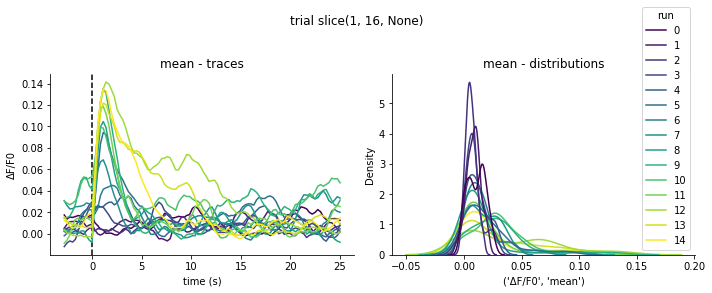

In [22]:
figs[f'{ykey_postpro} aggregate traces'] = plot_aggregate_traces(
    xtimeseries, fps, ykey_postpro, hue=Label.RUN, itrial=slice(1, 16),
    icorrect=None if ykey_postpro == Label.ZSCORE else 'baseline')

## Statistics (response metrics & cell classification)

### Create statistics dataframe

<span style="color:orange">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [23]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: xtimeseries.index.unique(k) for k in xtimeseries.index.names}

# Create stats dataframes
logger.info('creating statistics dataframe')
stats = pd.DataFrame()

# Add information about pulse and time-average acoustic intensity to info table
output_info_table = add_intensity_to_table(output_info_table)

# Add experimental info to stats
if Label.P not in stats:
    logger.info('adding experimental info to stats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels(
        [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    stats = pd.concat([exp_output_table, stats], axis=1) 

# Add info about discarded trials
logger.info('adding "discarded" labels...')
stats[Label.DISCARDED] = False
stats.loc[pd.IndexSlice[:, :, ITRIALS_DISCARD], Label.DISCARDED] = True

logger.info('stats table:')
stats

 13/06/2022 09:00:53: creating statistics dataframe
 13/06/2022 09:00:53: deriving acoustic intensity information...
 13/06/2022 09:00:53: adding experimental info to stats...
 13/06/2022 09:00:54: adding "discarded" labels...
 13/06/2022 09:00:54: stats table:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
0   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
438 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  
ROI run trial                                                     
0   0   0         869        0.000000         0.00000       True  
        1         869        0.000000         0.00000      False  
        2         869        0.000000         0.00000      False  
        3         869        0.000000         0.00000      False  
        4         869        0.000000         0.00000      False  
...               ...             ...             ...        ...  
438 14  11        863       19.784475        15.82758      False  
        12        863       19.784475        15.82758      False  
        13        863       19.784475        15.82758      False  
        14        863       19.784475        15.82758      False  
        15        863       19.784475        15.82758      False  

[105360 rows x 10 columns]

### Visualize run order (as processed by suite2p)

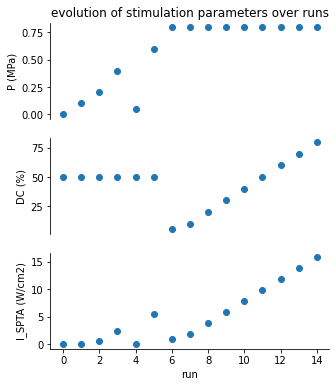

In [24]:
figs['protocol_summary'] = plot_protocol(
    output_info_table,
    xkey=Label.RUN,
    ykeys=(Label.P, Label.DC, Label.ISPTA))

### Identify & reject trials with significant stimulus-evoked motion artefact

 13/06/2022 09:00:54: computing diplacement velocity over time from registration offsets...
 13/06/2022 09:00:54: correcting displacement velocity at indices [1, 10] to compensate for frames substitution...
 13/06/2022 09:00:55: identified 23 / 240 trials (9.6%) with peak displacement higher than 2.0 um/s


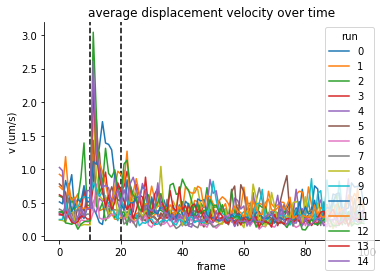

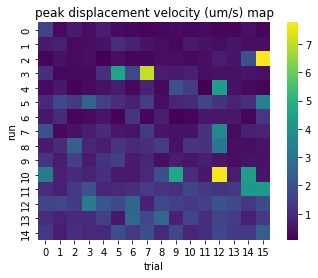

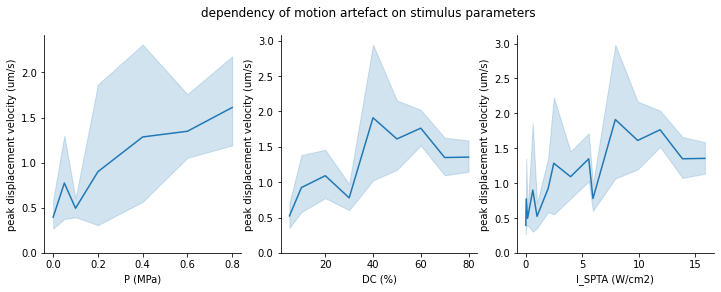

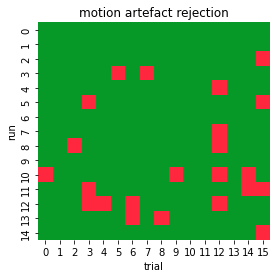

In [25]:
# Create (run, trial, frame) multi-index
exp_mux_keys = [Label.RUN, Label.TRIAL, Label.FRAME]
exp_mux = pd.MultiIndex.from_product(
    [index_dims[k] for k in exp_mux_keys], names=exp_mux_keys)

# Compute displacement velocity profiles
if isinstance(ss, StackSubstitutor):
    isubs = [max(x) for x in ss.submap if abs(x[0] - x[1]) == 1]
else:
    isubs = None
vdisp = compute_displacement_velocity(
    s2p_ops, exp_mux, 
    daq_settings['micronsPerPixel'],
    1 / daq_settings['framePeriod'],
    isubs=isubs)

# Plot average displacement velocity profile for each run
figs['vdisp_profiles'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('average displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    hue=Label.RUN, ci=None, palette='tab10')

# Compute peak of displacement velocity within response window for each run and trial
# and assess of motion exceeded threshold
from constants import VDISP_THR
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_peaks = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(
    find_response_peak).rename(Label.PEAK_DISP_VEL)
vdisp_peaks = vdisp_peaks.to_frame()
vdisp_peaks[Label.MOTION] = vdisp_peaks[Label.PEAK_DISP_VEL] > VDISP_THR
nmotion = vdisp_peaks[Label.MOTION].sum()
ntot = len(vdisp_peaks)

# Add peak displacement velocity and motion status info to stats
exp_vdisp_peaks = repeat_along_new_dim(
    vdisp_peaks, Label.ROI, stats.index.unique(Label.ROI)
    ).swaplevel(0, 2).swaplevel(1, 2).sort_index()
stats = pd.concat([stats, exp_vdisp_peaks], axis=1)

# Add stimulus parameters info to vdisp peaks dataframe
vdisp_peaks = pd.concat([vdisp_peaks, repeat_along_new_dim(
    output_info_table[[Label.P, Label.DC, Label.ISPTA]],
    Label.TRIAL, exp_mux.unique(level=Label.TRIAL))], axis=1)

# Plot peak displacement velocity heatmap
figs['peakvdisp_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(f'{Label.PEAK_DISP_VEL} map')
sns.heatmap(vdisp_peaks[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)

# Plot dependency of motion artefact on pressure & duty cycle 
figs['peakvdisp_vs_stimparams'], axes = plt.subplots(1, 3, figsize=(12, 4))
figs['peakvdisp_vs_stimparams'].suptitle('dependency of motion artefact on stimulus parameters')
for ax, xkey in zip(axes, [Label.P, Label.DC]):
    sns.lineplot(
        data=get_xdep_data(vdisp_peaks, xkey), x=xkey, y=Label.PEAK_DISP_VEL, ax=ax)
sns.lineplot(data=vdisp_peaks, x=Label.ISPTA, y=Label.PEAK_DISP_VEL, ax=axes[-1])
for ax in axes:
    sns.despine(ax=ax)
    ax.set_ylim(0, ax.get_ylim()[1])

# Plot motion artefact rejection heatmap
figs['motionreject_map'], ax = plt.subplots()
ax.set_title('motion artefact rejection')
ax.set_aspect(1.)
sns.heatmap(vdisp_peaks[Label.MOTION].unstack(), ax=ax, cmap=rdgn, cbar=False)

# Log identified motion trials
logger.info(
    f'identified {nmotion} / {ntot} trials ({nmotion / ntot * 1e2:.1f}%)'
    f' with peak displacement higher than {VDISP_THR} um/s')

### Visualize traces per run across valid trials for chosen post-processing variable

 13/06/2022 09:00:55: identifying samples not without [discarded, motion] tags
 13/06/2022 09:00:55: adding expanded validity index to timeseries ...
 13/06/2022 09:01:00: filtering timeseries ...
 13/06/2022 09:01:03: grouping data by ['run', 'frame'] and averaging...
 13/06/2022 09:01:03: adding time info to table...


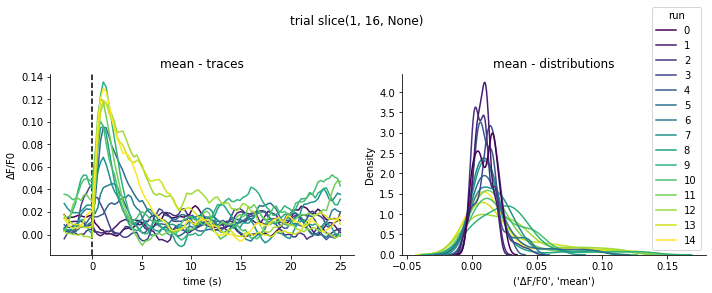

In [26]:
vtimeseries = valid_timeseries(xtimeseries, stats)
figs[f'{ykey_postpro} aggregate traces no motion'] = plot_aggregate_traces(
    vtimeseries, fps, ykey_postpro, hue=Label.RUN, itrial=slice(1, 16),
    icorrect=None if ykey_postpro == Label.ZSCORE else 'baseline')

### Identify & reject trials with outlier data points

 13/06/2022 09:01:04: identifying trials with ΔF/F0 data points outside (-1.1976, 1.1965) interval...
 13/06/2022 09:01:14: identified 1711 / 105360 (1.62%) trials with outlier data points


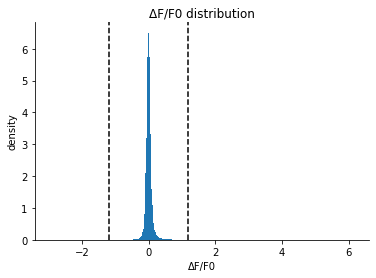

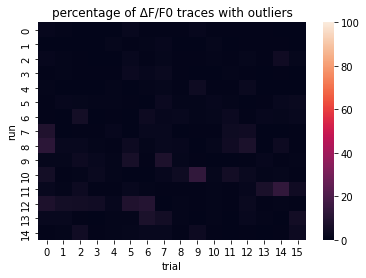

In [27]:
# Estimate interval of resonable data values
from constants import NSTD_DEV_THR
ymed, ystd = xtimeseries[ykey_postpro].median(), xtimeseries[ykey_postpro].std()
ystd = xtimeseries[ykey_postpro].std()
ybounds = (ymed - NSTD_DEV_THR * ystd, ymed + NSTD_DEV_THR * ystd)

# Identify trials with data points outside of this range
logger.info(
    f'identifying trials with {ykey_postpro} data points outside '
    f'({ybounds[0]:.4f}, {ybounds[1]:.4f}) interval...')
stats[Label.OUTLIER] = xtimeseries[ykey_postpro].groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).apply(lambda s: not is_bounded(s, *ybounds))
pct_outlier = stats[Label.OUTLIER].sum() / len(stats) * 100
logger.info(
    f'identified {stats[Label.OUTLIER].sum()} / {len(stats)} ({pct_outlier:.2f}%) trials '
    'with outlier data points')

# Plot histogram distribution with identified outliers
figs[f'{ykey_postpro} distribution'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title(f'{ykey_postpro} distribution')
ax.set_xlabel(ykey_postpro)
ax.set_ylabel('density')
ax.hist(xtimeseries[ykey_postpro], bins=500, density=True)
for y in ybounds:
    ax.axvline(y, c='k', ls='--')

# Plot percentage of traces containing outliers per run & trial
nROIs = len(stats.index.unique(Label.ROI))
noutliers_per_cond_trial = stats[Label.OUTLIER].groupby([Label.RUN, Label.TRIAL]).sum()
pct_outliers_per_cond_trial = noutliers_per_cond_trial / nROIs * 100
figs[f'{ykey_postpro} pct outlier map'], ax = plt.subplots()
ax.set_title(f'percentage of {ykey_postpro} traces with outliers')
sns.heatmap(pct_outliers_per_cond_trial.unstack(), ax=ax, vmin=0, vmax=100);

### Visualize traces per run across valid trials for chosen post-processing variable

 13/06/2022 09:01:15: identifying samples not without [discarded, motion, outlier] tags
 13/06/2022 09:01:15: adding expanded validity index to timeseries ...
 13/06/2022 09:01:18: filtering timeseries ...
 13/06/2022 09:01:20: grouping data by ['run', 'frame'] and averaging...
 13/06/2022 09:01:21: adding time info to table...


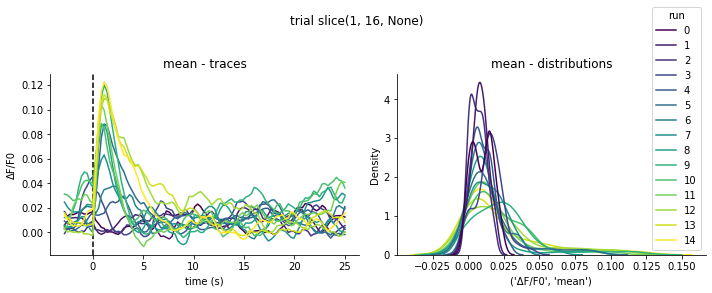

In [28]:
vtimeseries = valid_timeseries(xtimeseries, stats)
figs[f'{ykey_postpro} aggregate traces no motion'] = plot_aggregate_traces(
    vtimeseries, fps, ykey_postpro, hue=Label.RUN, itrial=slice(1, 16),
    icorrect=None if ykey_postpro == Label.ZSCORE else 'baseline')

### Identify & reject trials with pre-stimulus activity and/or "inhibition"

 13/06/2022 09:01:21: analyzing ΔF/F0 pre-stimulus levels...
 13/06/2022 09:01:21: setting pre-stimulus Z(ΔF/F0) absolute outlier threshold to 2.386
 13/06/2022 09:01:21: identified:
   - 10806/105360 trials (10.26%) significant pre-stimulus activity
   - 4673/105360 trials (4.44%) significant pre-stimulus inhibition
   - 15110/105360 trials (14.34%) pre-stimulus outlier data
 13/06/2022 09:01:22: identified 8/240 trials (3.3%) with more than 50.0 % pre-active cells


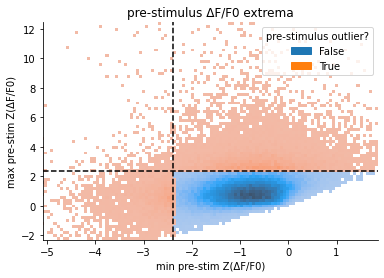

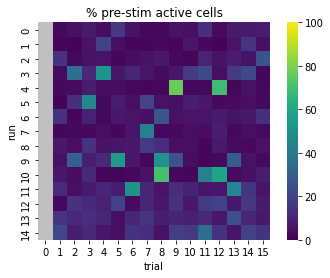

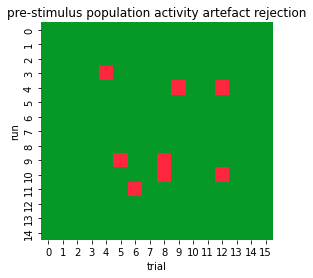

In [29]:
# Compute min and max z-score in pre-stimulus window for each trial
zprestim_min = f'min pre-stim {Label.ZSCORE}'
zprestim_max = f'max pre-stim {Label.ZSCORE}'
logger.info(f'analyzing {ykey_postpro} pre-stimulus levels...')
from constants import FrameIndex
y_prestim = xtimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
stats[zprestim_max] = y_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).max()
stats[zprestim_min] = y_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).min()

# Classify pre-stimulus state on a per-ROI basis for each trial
zthr_prestim = get_zscore_maximum(PTHR_DETECTION, FrameIndex.PRESTIM)
logger.info(
    f'setting pre-stimulus {Label.ZSCORE} absolute outlier threshold to {zthr_prestim:.3f}')
stats[Label.PRESTIM_ACTIVITY] = stats[zprestim_max] > zthr_prestim
stats[Label.PRESTIM_INHIBITION] = stats[zprestim_min] < -zthr_prestim
stats[Label.PRESTIM_OUTLIER] = stats[[
    Label.PRESTIM_ACTIVITY, Label.PRESTIM_INHIBITION]].any(axis=1)
npreacts = stats[Label.PRESTIM_ACTIVITY].sum()
npreinhibs = stats[Label.PRESTIM_INHIBITION].sum()
npreoutliers = stats[Label.PRESTIM_OUTLIER].sum()
ntot = len(stats)
outlierslog = [
    (stats[Label.PRESTIM_ACTIVITY].sum(), 'significant pre-stimulus activity'),
    (stats[Label.PRESTIM_INHIBITION].sum(), 'significant pre-stimulus inhibition'),
    (stats[Label.PRESTIM_OUTLIER].sum(), 'pre-stimulus outlier data')
]
outlierslog = '\n'.join([
    f'   - {n}/{ntot} trials ({n / ntot * 100:.2f}%) {k}' for n, k in outlierslog])
logger.info(f'identified:\n{outlierslog}')

# Plot 2D histogram of pre-stimulus extrema
figs['prestim extrema dist'], ax = plt.subplots()
ax.set_title(f'pre-stimulus {ykey_postpro} extrema')
sns.despine(ax=ax)
sns.histplot(
    data=stats, x=zprestim_min, y=zprestim_max, ax=ax, bins=400,
    hue=Label.PRESTIM_OUTLIER)
ax.axvline(-zthr_prestim, c='k', ls='--')
ax.axhline(zthr_prestim, c='k', ls='--')
ax.set_xlim(stats[zprestim_min].quantile(.001), stats[zprestim_min].quantile(.999))
ax.set_ylim(stats[zprestim_max].quantile(.001), stats[zprestim_max].quantile(.999))

# Compute and plot fraction of ROIs with pre-stimulus activity for each run & trial
nROIs = len(stats.index.unique(level=Label.ROI))
npreacts_per_run_trial = stats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum()
isdiscarded = stats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
npreacts_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_preacts_per_run_trial = (npreacts_per_run_trial / nROIs * 1e2).rename(Label.PCT_PREACTIVE_CELLS)
figs['pct_prestim_activity_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(Label.PCT_PREACTIVE_CELLS)
sns.heatmap(pct_preacts_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)

# Label trials with large fraction of pre-active cells
from constants import PCT_PREACTIVE_THR
pop_preact_per_run_trial = (pct_preacts_per_run_trial > PCT_PREACTIVE_THR).rename(
    Label.PRESTIM_POP_ACTIVITY)
npreacts_pop, ntot = pop_preact_per_run_trial.sum(), len(pop_preact_per_run_trial)
logger.info(
    f'identified {npreacts_pop}/{ntot} trials ({npreacts_pop / ntot * 100:.1f}%)'
    f' with more than {PCT_PREACTIVE_THR} % pre-active cells')
exp_pop_preact_per_run_trial = repeat_along_new_dim(
    pop_preact_per_run_trial.to_frame(),
    Label.ROI, stats.index.unique(level=Label.ROI)).reorder_levels(
    [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
stats[Label.PRESTIM_POP_ACTIVITY] = exp_pop_preact_per_run_trial

# Plot pre-stimulus population activity rejection heatmap
figs['prestim reject map'], ax = plt.subplots()
ax.set_title('pre-stimulus population activity artefact rejection')
ax.set_aspect(1.)
sns.heatmap(pop_preact_per_run_trial.unstack(), ax=ax, cmap=rdgn, cbar=False);

### Visualize traces per run across valid trials for chosen post-processing variable

 13/06/2022 09:01:23: identifying samples not without [discarded, motion, outlier, pre-stim cell activity?, pre-stim population activity?, pre-stim cell inhibition?] tags
 13/06/2022 09:01:23: adding expanded validity index to timeseries ...
 13/06/2022 09:01:27: filtering timeseries ...
 13/06/2022 09:01:29: grouping data by ['run', 'frame'] and averaging...
 13/06/2022 09:01:29: adding time info to table...


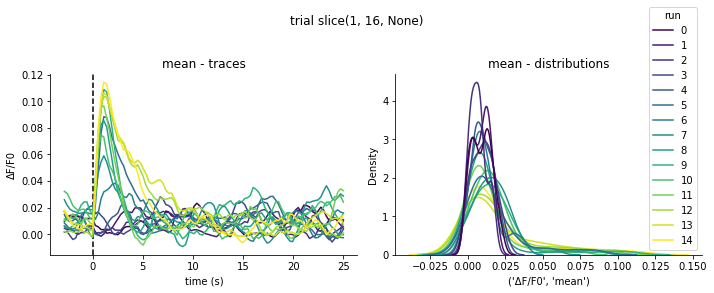

In [30]:
vtimeseries = valid_timeseries(xtimeseries, stats)
figs[f'{ykey_postpro} aggregate traces valid'] = plot_aggregate_traces(
        vtimeseries, fps, ykey_postpro, hue=Label.RUN, itrial=slice(1, 16),
        icorrect=None if ykey_postpro == Label.ZSCORE else 'baseline')

### Compute average timeseries and states over valid trials

In [31]:
# Compute number of valid trials per ROI and run
logger.info('computing number of valid trials per ROI and run...')
nvalidtrials_per_run = vtimeseries.loc[pd.IndexSlice[:, :, :, 0]].groupby(
    [Label.ROI, Label.RUN]).count()[Label.ZSCORE]
zfactors = np.sqrt(nvalidtrials_per_run)

# Restrict timeseries to valid trials and average over trials
logger.info('computing trial-averaged timeseries per ROI & run, over valid trials...') 
trialavg_xtimeseries = vtimeseries.groupby([Label.ROI, Label.RUN, Label.FRAME]).mean()

# Rescale z-scores
logger.info('rescaling z-scores post-averaging...')
zfactors_exp = expand_to_match(zfactors, trialavg_xtimeseries.index)
trialavg_xtimeseries[Label.ZSCORE] = trialavg_xtimeseries[Label.ZSCORE] * zfactors_exp

# Restrict stats to valid trials and average over them
logger.info('computing trial-averaged stats over valid trials...')
valid_stats = valid(stats)
trialavg_stats = get_trial_averaged(valid_stats)
trialavg_stats

 13/06/2022 09:01:30: computing number of valid trials per ROI and run...
 13/06/2022 09:01:30: computing trial-averaged timeseries per ROI & run, over valid trials...
 13/06/2022 09:01:30: rescaling z-scores post-averaging...
 13/06/2022 09:01:31: computing trial-averaged stats over valid trials...
 13/06/2022 09:01:31: identifying samples not without [discarded, motion, outlier, pre-stim cell activity?, pre-stim population activity?, pre-stim cell inhibition?] tags


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  \
ROI run                                                                     
0   0    line3         100.0           0.2  3.56     0.00    50.0   869.0   
    1    line3         100.0           0.2  3.56     0.10    50.0   867.0   
    2    line3         100.0           0.2  3.56     0.20    50.0   866.0   
    3    line3         100.0           0.2  3.56     0.40    50.0   865.0   
    4    line3         100.0           0.2  3.56     0.05    50.0   868.0   
...        ...           ...           ...   ...      ...     ...     ...   
438 10   line3         100.0           0.2  3.56     0.80    40.0   856.0   
    11   line3         100.0           0.2  3.56     0.80    50.0   855.0   
    12   line3         100.0           0.2  3.56     0.80    60.0   861.0   
    13   line3         100.0           0.2  3.56     0.80    70.0   862.0   
    14   line3         100.0           0.2  3.56     0.80    80.0   863.0   

         I_SPPA (W/cm2)  I_SPTA (W/cm2)  peak displacement velocity (um/s)  \
ROI run                                                                      
0   0          0.000000        0.000000                           0.316575   
    1          0.309132        0.154566                           0.487810   
    2          1.236530        0.618265                           0.468856   
    3          4.946119        2.473059                           0.449410   
    4          0.077283        0.038642                           0.443769   
...                 ...             ...                                ...   
438 10        19.784475        7.913790                           0.767617   
    11        19.784475        9.892238                           1.207067   
    12        19.784475       11.870685                           1.598214   
    13        19.784475       13.849133                           1.207355   
    14        19.784475       15.827580                           1.297150   

         max pre-stim Z(ΔF/F0)  min pre-stim Z(ΔF/F0)  pre-stimulus outlier?  
ROI run                                                                       
0   0                 0.574540              -0.597728                    0.0  
    1                 0.180947              -0.503763                    0.0  
    2                 0.535574              -0.436759                    0.0  
    3                 0.657017              -0.868336                    0.0  
    4                 0.443748              -0.553745                    0.0  
...                        ...                    ...                    ...  
438 10                1.446177              -0.988085                    0.0  
    11                0.989544              -0.972146                    0.0  
    12                1.299098              -1.578310                    0.0  
    13                1.344135              -1.259291                    0.0  
    14                1.166705              -1.361664                    0.0  

[6583 rows x 13 columns]

### Visualize relative trial-averaged traces and heatmaps

 13/06/2022 09:01:39: grouping data by ['run', 'frame'] and averaging...
 13/06/2022 09:01:39: adding time info to table...
 13/06/2022 09:01:39: adding time info to table...
 13/06/2022 09:01:39: plotting ΔF/F0 trial heatmaps...


15it [00:02,  5.37it/s]                        


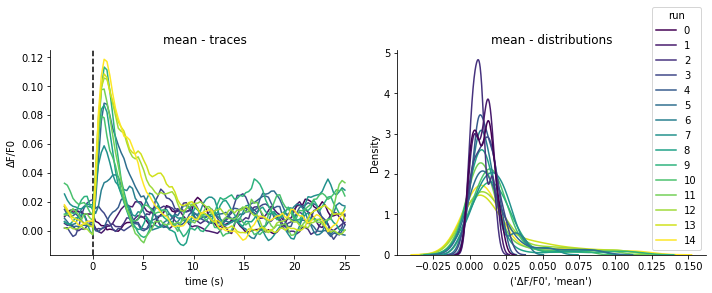

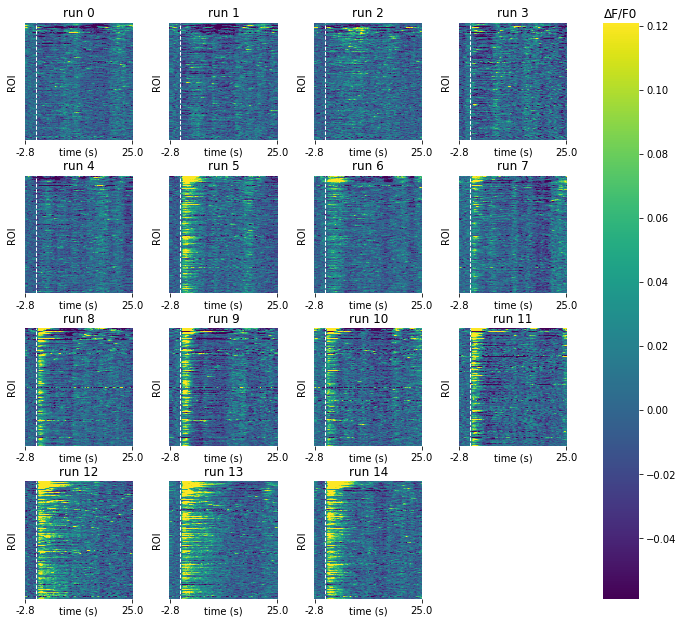

In [32]:
figs[f'{ykey_postpro} trial-averaged aggregate traces valid'] = plot_aggregate_traces(
    trialavg_xtimeseries, fps, ykey_postpro, hue=Label.RUN,
    icorrect=None if ykey_postpro == Label.ZSCORE else 'baseline')
figs['trial heatmaps'] = plot_trial_heatmap(
    trialavg_xtimeseries, ykey_postpro, fps, col=Label.RUN, quantile_bounds=(.01, .99))

### Response type, pressure & duty cycle dependency

 13/06/2022 09:01:43: merging timeseries and stats information...
 13/06/2022 09:01:43: adding time info to table...
 13/06/2022 09:01:44: sub-indexing data...
 13/06/2022 09:01:44: filtering data...
 13/06/2022 09:01:44: cross-checking filters...
 13/06/2022 09:01:44: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 13/06/2022 09:01:45: sub-indexing data...
 13/06/2022 09:01:45: filtering data...
 13/06/2022 09:01:45: cross-checking filters...
 13/06/2022 09:01:45: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


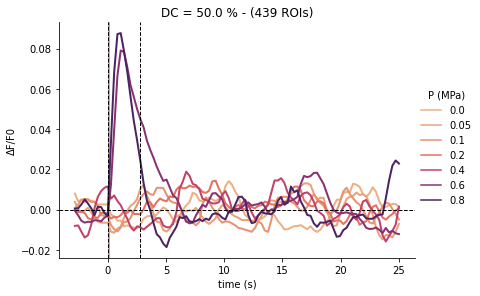

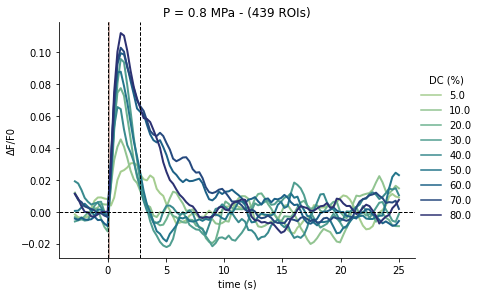

In [33]:
plt_data = get_plot_data(trialavg_xtimeseries, trialavg_stats)
tracekwargs = dict(
    ci=None,
    yref=0.,
)
# Pressure dependency
figs[f'{ykey_postpro} traces DC={DC_REF}%'] = plot_responses(
    plt_data, ykey=ykey_postpro, DC=DC_REF, hue=Label.P, **tracekwargs)
# Duty cycle dependency
figs[f'{ykey_postpro} traces P={P_REF}MPa'] = plot_responses(
    plt_data, ykey=ykey_postpro, P=P_REF, hue=Label.DC, **tracekwargs)

### Assess pre-stim and post-stim activity levels, and their differences

 13/06/2022 09:01:47: applying <lambda> function on ΔF/F0 in [5-10] index window across ROI, run ...
 13/06/2022 09:01:47: applying <lambda> function on ΔF/F0 in [10-19] index window across ROI, run ...


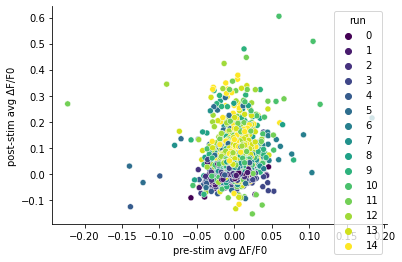

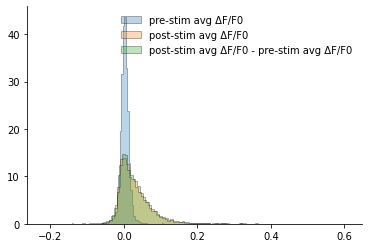

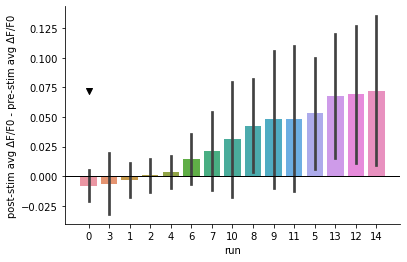

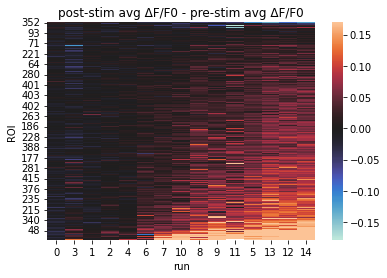

In [34]:
# Compute response average in pre-stimulus and response windows for each ROI & run
ykey_poststim_avg = f'post-stim avg {ykey_postpro}'
ykey_prestim_avg = f'pre-stim avg {ykey_postpro}'
from constants import FrameIndex
trialavg_stats[ykey_prestim_avg] = apply_in_window(
    lambda x: x.mean(), trialavg_xtimeseries, ykey_postpro, FrameIndex.PRESTIM)
trialavg_stats[ykey_poststim_avg] = apply_in_window(
    lambda x: x.mean(), trialavg_xtimeseries, ykey_postpro, FrameIndex.RESPONSE)

# Plot their co-distribution
figs[f'{ykey_prestim_avg}-{ykey_poststim_avg} codist'], ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=trialavg_stats, x=ykey_prestim_avg, y=ykey_poststim_avg,
    hue=Label.RUN, palette='viridis', legend='full')

# Compute response strength as their difference
ykey_diff = f'{ykey_poststim_avg} - {ykey_prestim_avg}'
trialavg_stats[ykey_diff] = trialavg_stats[ykey_poststim_avg] - trialavg_stats[ykey_prestim_avg]

# Plot response strength histogram distributions
figs[f'{ykey_diff} histogram'], ax = plt.subplots()
sns.despine(ax=ax)
for ykey in [ykey_prestim_avg, ykey_poststim_avg, ykey_diff]:
    ax.hist(
        trialavg_stats[ykey], label=ykey, bins=100, histtype='stepfilled',
        alpha=0.3, density=True, ec='k')
ax.legend(frameon=False)

# Order runs and ROIs by increasing response strength
run_order = trialavg_stats[ykey_diff].groupby(
    Label.RUN).mean().sort_values().index
ROI_order = trialavg_stats[ykey_diff].groupby(
    Label.ROI).mean().sort_values().index

# Plot response strength vs. run
figs[f'{ykey_diff} vs run'], ax = plt.subplots()
sns.despine(ax=ax)
sns.barplot(
    ax=ax, data=trialavg_stats.reset_index(level=Label.RUN),
    x=Label.RUN, y=ykey_diff, order=run_order, ci='sd')
# Add zero line
ax.axhline(0., c='k', lw=1)
# Add marker for zero-pressure run
if irun_P0 is not None:
    irun_P0_ordered = run_order.values.tolist().index(irun_P0)
    ax.scatter(irun_P0_ordered, .5 * ax.get_ylim()[1], marker='v', c='k')

# Plot response strength heatmap per ROI & run
figs[f'{ykey_diff} map'], ax = plt.subplots()
ax.set_title(ykey_diff)
med = trialavg_stats[ykey_diff].median()
std = trialavg_stats[ykey_diff].std()
sns.heatmap(
    trialavg_stats[ykey_diff].unstack().reindex(
        ROI_order, axis=0).reindex(run_order, axis=1),
    center=0., ax=ax, vmax=med + 3 * std);


### Identify response type for each ROI & condition using statistical tests 

 13/06/2022 09:01:48: testing for significant ΔF/F0 differences between pre- and post-stimulus windows...
 13/06/2022 09:01:53: classifying responses...


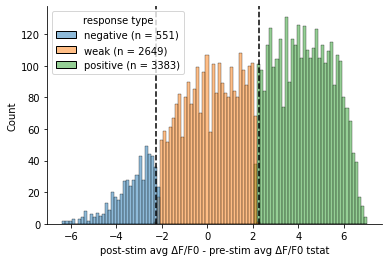

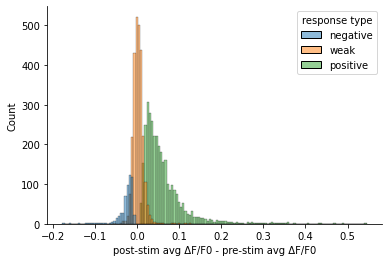

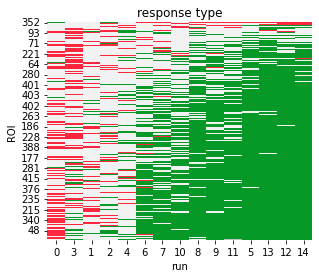

In [35]:
# Test for significant differences pre-post
logger.info(f'testing for significant {ykey_postpro} differences between pre- '
            'and post-stimulus windows...')
res = trialavg_xtimeseries[ykey_postpro].groupby([Label.ROI, Label.RUN]).agg(pre_post_ttest)
res = pd.DataFrame(
    res.tolist(), columns=['tstat', 'pval'],
    index=trialavg_xtimeseries.groupby([Label.ROI, Label.RUN]).first().index)
# Add these fields to trialavg stats
for k in res.columns:
    trialavg_stats[f'{ykey_diff} {k}'] = res[k]
# Classify responses
logger.info('classifying responses...')
trialavg_stats[Label.RESP_TYPE] = (
    (res['pval'] < PTHR_DETECTION).astype(int) * np.sign(res['tstat']).astype(int))
trialavg_stats[Label.RESP_TYPE] = trialavg_stats[Label.RESP_TYPE].map(RTYPE_MAP)
counts_per_rtype = trialavg_stats[Label.RESP_TYPE].value_counts()

# Plot response t-stat histogram per resppnse type along with classification threshold(s)
tthr = pvalue_to_tscore(
    PTHR_DETECTION, FrameIndex.RESPONSE.stop - FrameIndex.RESPONSE.start,
    directional=False)
figs['response t-stats histogram'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    trialavg_stats, x=f'{ykey_diff} tstat', bins=100,
    hue=Label.RESP_TYPE, hue_order=get_default_rtypes())
for x in [-tthr, tthr]:
    ax.axvline(x, ls='--', c='k')
leg = ax.get_legend()
for t in leg.texts:
    s = t.get_text()
    cs = counts_per_rtype.loc[s]
    t.set_text(f'{s} (n = {cs:.0f})')

# Plot response strength histogram with condition type color code 
figs[f'{ykey_diff} per condition type'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(data=trialavg_stats, x=ykey_diff, hue=Label.RESP_TYPE)

# Plot response type map per ROI & run
figs[f'{ykey_diff} heatmap'], ax = plt.subplots(figsize=(4.75, 4))
ax.set_title(Label.RESP_TYPE)
poscondsmap = trialavg_stats[Label.RESP_TYPE].replace(
    swapdict(RTYPE_MAP)).unstack().reindex(ROI_order, axis=0).reindex(run_order, axis=1)
sns.heatmap(poscondsmap, ax=ax, cbar=False, cmap=gnrd);

### Identify responding cells based on the number of occurence of each response category

 13/06/2022 09:01:55: cell breakdown:
  - positive: 378 (86.1%)
  - weak: 56 (12.8%)
  - negative: 5 (1.1%)


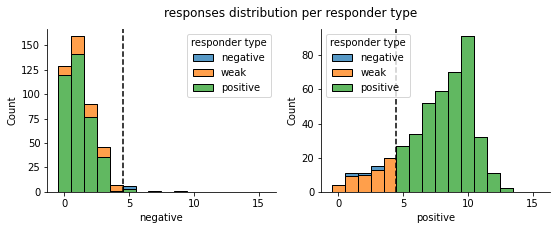

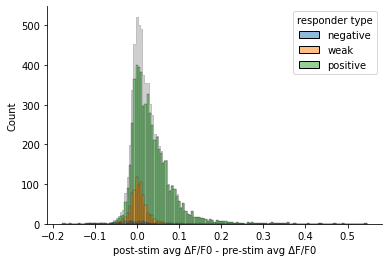

In [36]:
# Compute number of occurences per response type per ROI
roistats = trialavg_stats[Label.RESP_TYPE].groupby(
    Label.ROI).value_counts().unstack().replace(np.nan, 0.).astype(int)

# Classify ROIs based on number of responsive conditions
from constants import NPOSCONDS_THR
roistats[Label.ROI_RESP_TYPE] = 'weak'
roistats.loc[roistats['negative'] >= NPOSCONDS_THR, Label.ROI_RESP_TYPE] = 'negative'
roistats.loc[roistats['positive'] >= NPOSCONDS_THR, Label.ROI_RESP_TYPE] = 'positive'

# Add roistats to stats and trial-averaged stats
valid_stats = expand_and_add(roistats, valid_stats.copy())
trialavg_stats = expand_and_add(roistats, trialavg_stats.copy())

# Log number and percentage of cells of each type identified
ncells_per_type = roistats[Label.ROI_RESP_TYPE].value_counts()
ncells_tot = ncells_per_type.sum()
logstr = []
for rtype, count in ncells_per_type.iteritems():
    logstr.append(f'  - {rtype}: {count} ({count / ncells_tot * 100:.1f}%)')
logstr = "\n".join(logstr)
logger.info(f'cell breakdown:\n{logstr}')

# # Plot histogram distribution of # positive and negative responses per type
figs['responders type scatter'], axes = plt.subplots(1, 2, figsize=(9, 3))
for ax, k in zip(axes, ['negative', 'positive']):
    sns.despine(ax=ax)
    sns.histplot(
        data=roistats, ax=ax, x=k, hue=Label.ROI_RESP_TYPE,
        hue_order=get_default_rtypes(), 
        bins=np.arange(nruns + 2) - 0.5, multiple='stack')
    ax.axvline(NPOSCONDS_THR - 0.5, c='k', ls='--')
figs['responders type scatter'].suptitle('responses distribution per responder type')

# Plot response strength histogram with cell classification
figs['resp strength vs cell class'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    data=trialavg_stats, x=ykey_diff, color='silver', element='step')
sns.histplot(
    data=trialavg_stats, x=ykey_diff,
    hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes());

### Save trial-averaged traces and stats to disk

In [58]:
trialavg_dir = get_output_equivalent(postpro_dir, 'post-processed', 'trial-averaged')
trialavg_fpath = os.path.join(trialavg_dir, os.path.basename(postpro_fpath))
map_ops = {
    'micronsPerPixel': daq_settings['micronsPerPixel'],
    'Lx': s2p_ops['Lx'],
    'Ly': s2p_ops['Ly'],
    'Vcorr': s2p_ops['Vcorr'],
    'max_proj': s2p_ops['max_proj']
}
save_trialavg_dataset(
    trialavg_fpath, trialavg_xtimeseries, trialavg_stats, ROI_masks, map_ops)

 13/06/2022 09:29:54: saving trial-averaged timeseries data...
 13/06/2022 09:29:54: saving trial-averaged stats data...
 13/06/2022 09:29:54: saving ROI masks...
 13/06/2022 09:29:54: saving mapping options...


/Users/tlemaire/Documents/code/usnm2p/fileops.py:465: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  store['map_ops'] = pd.Series(map_ops)


## Results visualization

### Spatial distribution of cells per response type

 13/06/2022 09:33:18: plotting cells map color-coded by response type...
 13/06/2022 09:33:18: extracting responses types per ROI...


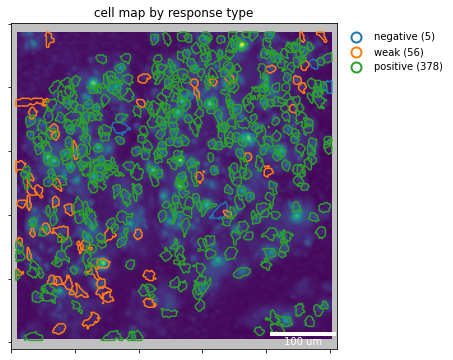

In [59]:
figs['cellmap'] = plot_cell_map(
    ROI_masks, trialavg_stats, map_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='Vcorr', mode='contour')

### Response strength dependency on cell response type

 10/06/2022 17:28:22: sub-indexing data...
 10/06/2022 17:28:22: filtering data...
 10/06/2022 17:28:22: cross-checking filters...
 10/06/2022 17:28:22: grouping by responder type, averaging, estimating confidence intervals and plotting mean post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. P (MPa) ...
 10/06/2022 17:28:22: sub-indexing data...
 10/06/2022 17:28:22: filtering data...
 10/06/2022 17:28:22: cross-checking filters...
 10/06/2022 17:28:22: grouping by responder type, averaging, estimating confidence intervals and plotting mean post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. DC (%) ...


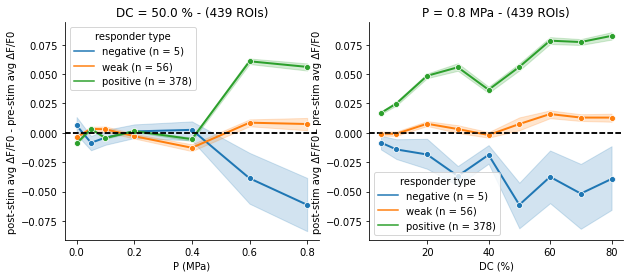

In [39]:
figs[f'{ykey_diff} dependency'] = plot_stimparams_dependency_per_response_type(
    trialavg_stats, ykey_diff, yref=0)

### Response type, pressure & duty cycle dependency, per category

 10/06/2022 17:28:23: merging timeseries and stats information...
 10/06/2022 17:28:24: adding time info to table...
 10/06/2022 17:28:24: sub-indexing data...
 10/06/2022 17:28:24: filtering data...
 10/06/2022 17:28:24: cross-checking filters...
 10/06/2022 17:28:24: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 10/06/2022 17:28:26: sub-indexing data...
 10/06/2022 17:28:26: filtering data...
 10/06/2022 17:28:26: cross-checking filters...
 10/06/2022 17:28:26: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


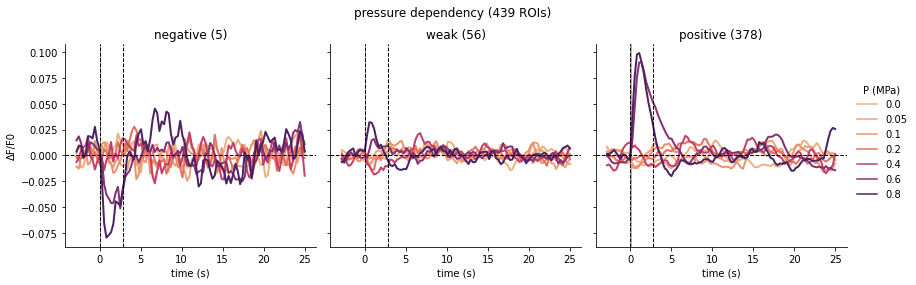

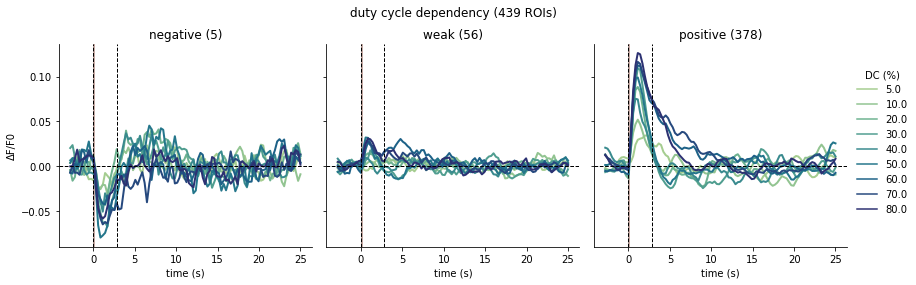

In [40]:
plt_data = get_plot_data(trialavg_xtimeseries, trialavg_stats)
nROIs = len(trialavg_stats.index.unique(level=Label.ROI))
tracekwargs = dict(
    height = 4,  # height of each figure axis
    aspect = 1.,  # width / height aspect ratio of each axis
    hide_col_prefix = True,
    col_count_key = Label.ROI,
    ci=None,
    yref=0.
)
# Pressure dependency
figs[f'{ykey_postpro} traces by type DC={DC_REF}%'] = plot_responses(
    plt_data, ykey=ykey_postpro, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, title=f'pressure dependency ({nROIs} ROIs)', **tracekwargs)
# Duty cycle dependency
figs[f'{ykey_postpro} traces by type P={P_REF}MPa'] = plot_responses(
    plt_data, ykey=ykey_postpro, P=P_REF, hue=Label.DC, 
    col=Label.ROI_RESP_TYPE, title=f'duty cycle dependency ({nROIs} ROIs)', **tracekwargs)

### Save figures

In [41]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figssuffix)

# Save stacks as GIFs if specified
if irun_inspect is not None and save_gifs:
    #raw and fileted stacks from specific run
    save_stack_to_gif(
        figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run)
    # registered stack (slice corresponding to specific run)
    save_stack_to_gif(
        figsdir, s2p_ops, title=outstack_label,
        ilabels=istimframes_stacked, bounds=runbounds)

 10/06/2022 17:28:29: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.06.10/figs_line3_20191112_mouse12_region1_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


### Notify upon completion

In [42]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{dataset_id} notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 10/06/2022 17:29:30: 20191112_mouse12_region1 notebook completed in 0:02:46.132499 s
